# Fake Review Detector

### Importing the necessary libraries

In [1]:
!pip install nltk


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import string
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\reshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Supressing warnings

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading the dataset

In [5]:
df = pd.read_csv(r"fake-reviews-dataset.csv")
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


## Preprocessing

In [6]:
df.drop(columns = {'category'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [7]:
df.rename(columns = {'text_': 'text'}, inplace = True)
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


### Label encoding

In [8]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    return df

In [9]:
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0)
df['target'] = df['target'].astype(int)

df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,5.0,CG,"love it, a great upgrade from the original. I...",0
2,5.0,CG,This pillow saved my back. I love the look and...,0
3,1.0,CG,"Missing information on how to use it, but it i...",0
4,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [10]:
df.drop(columns = {'rating', 'label'}, inplace = True)

In [11]:
df = df.sample(frac=1).reset_index(drop=True)
df.sample(10)

,text,target
20737,"I didn't buy this to lose weight, but to get h...",1
12212,This worked and was a perfect fit. It is a li...,0
39773,Daughter loves these dolls and has had many ho...,1
24445,The Bosch T234X Progressor wood saw has the sa...,0
6777,Great shoe with excellent grip. I wear an XL ...,0
33400,Really pretty and comfortable. I love it when...,1
39990,Great backpack case. Only reason I gave it 5 s...,0
35818,Looking for the perfect dessert for an afterno...,0
34851,The macaroon print is super soft and the desig...,0
27303,"Rabbie has no problem explaining his problems,...",1


In [12]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [13]:
df.duplicated().sum()

np.int64(20)

In [14]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

np.int64(0)

In [15]:
df['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

### Text preprocessing

In [16]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [17]:
df.head()

,text,target,num_characters,num_words,num_sentences
0,I love this! It's such a cute little design an...,0,77,20,2
1,"After waiting months for delays, this has fina...",0,675,159,10
2,We've been using the regular ice cube scoop fo...,0,212,51,3
3,This sci-fi story details the recurring story ...,1,253,50,2
4,The way Cassie and Andrei's relationship devel...,1,935,177,13


## EDA

In [18]:
df.describe()

,target,num_characters,num_words,num_sentences
count,40412.000000,40412.000000,40412.000000,40412.000000
mean,0.500223,351.365337,76.691131,5.277071
std,0.500006,369.871842,79.242859,4.915033
min,0.000000,24.000000,2.000000,1.000000
25%,0.000000,107.000000,24.000000,2.000000
50%,1.000000,198.000000,44.000000,3.000000
75%,1.000000,439.000000,96.000000,6.000000
max,1.000000,2827.000000,510.000000,133.000000


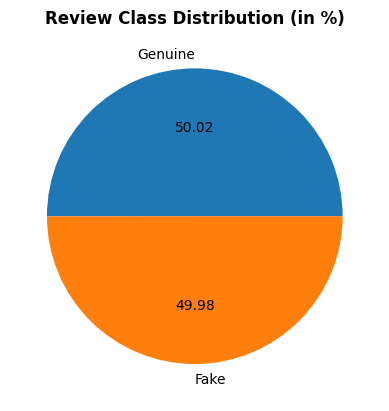

In [19]:
plt.pie(df['target'].value_counts(), labels=['Genuine', 'Fake'],autopct="%0.2f")

plt.title("Review Class Distribution (in %)", fontweight='bold')
plt.show()

### Correlational analysis

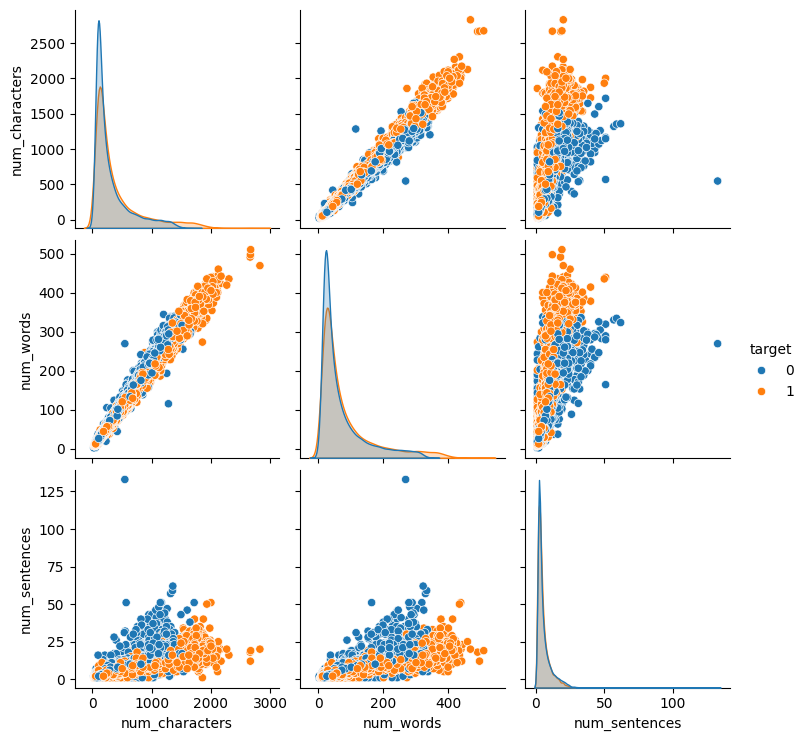

In [20]:
sns.pairplot(df,hue='target')
plt.show()

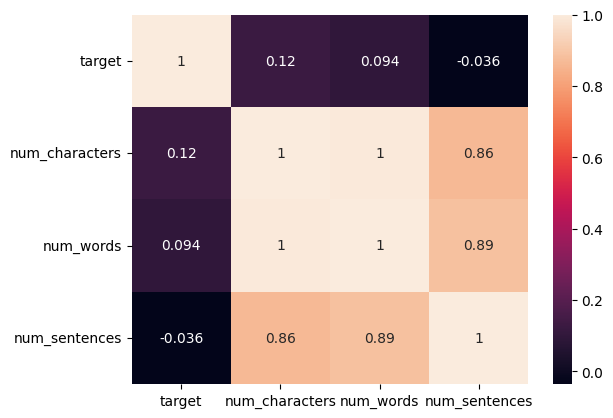

In [21]:
df_numeric = df.select_dtypes(include = 'number')
sns.heatmap(df_numeric.corr(),annot=True)

plt.show()

### Semantic analysis

In [22]:
ps = PorterStemmer()

In [23]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)

In [24]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [25]:
df['transformed_text'] = df['text'].apply(transform_text)

In [26]:
df.head()

,text,target,num_characters,num_words,num_sentences,transformed_text
0,I love this! It's such a cute little design an...,0,77,20,2,love cute littl design nice size size
1,"After waiting months for delays, this has fina...",0,675,159,10,wait month delay final come fruition reason ga...
2,We've been using the regular ice cube scoop fo...,0,212,51,3,use regular ice cube scoop month work well eas...
3,This sci-fi story details the recurring story ...,1,253,50,2,stori detail recur stori line man human treatm...
4,The way Cassie and Andrei's relationship devel...,1,935,177,13,way cassi andrei relationship develop believ h...


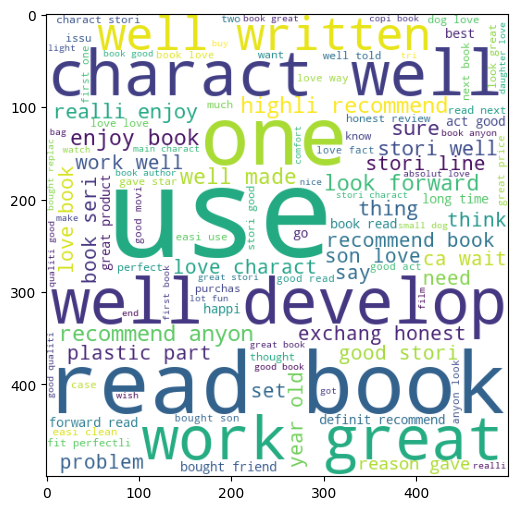

In [27]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(fake_wc)

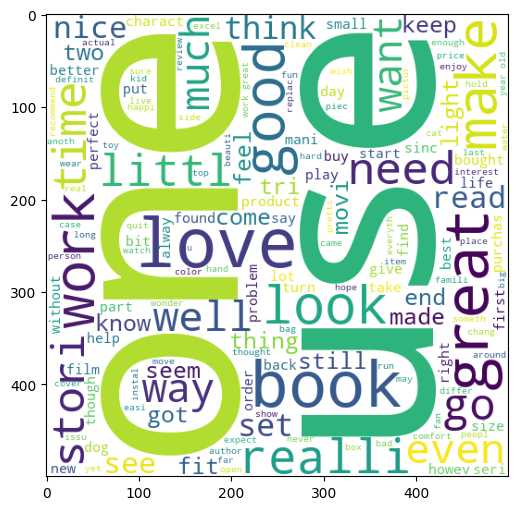

In [28]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
original_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(original_wc)

In [29]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [30]:
print(X.shape)
print(y.shape)

(40412, 3000)
(40412,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=32)

## Model training

In [32]:
# mnb = MultinomialNB()
# svc = SVC(probability=True, kernel='linear')

knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
xgb = XGBClassifier(n_estimators=50,random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [33]:
clfs = {
    'KN' : knc, 
    'DT' : dtc, 
    'LR' : lrc, 
    'RF' : rfc,
    'XGB' : xgb,
    'AdaBoost' : abc,
}

In [34]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    return accuracy,precision

## Model evaluation

In [35]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [36]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [37]:
performance_df.reset_index(drop = True)

,Algorithm,Accuracy,Precision
0,LR,0.853520,0.853523
1,RF,0.824075,0.825832
2,XGB,0.810590,0.811580
3,AdaBoost,0.681925,0.683058
4,DT,0.592602,0.644223
5,KN,0.505629,0.579084


In [38]:
# mnb = MultinomialNB()
# svc = SVC(probability=True, kernel='linear')

xgb = XGBClassifier(n_estimators=50,random_state=2)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [39]:
voting = VotingClassifier(estimators=[('LR', lrc), ('xgb', xgb), ('RF', rfc)],voting='soft')

In [40]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('LR',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=Non...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2))],
                 voting='soft')

In [41]:
y_pred = voting.predict(X_test)

print("Accuracy :", round(accuracy_score(y_test,y_pred), 2) * 100, "%")
print("Precision :", round(precision_score(y_test,y_pred), 2) * 100, "%")

Accuracy : 86.0 %
Precision : 86.0 %


## Pickling
Pickling the **Logistic Regression** model for use in the web application.

In [42]:
lrc.fit(X_train, y_train)

pickle.dump(lrc, open('model_v1.pkl', 'wb'))
pickle.dump(tfidf, open('vectorizer_v1.pkl','wb'))